# Homework 3 (Sun Yi)

In [11]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import math
%matplotlib inline

#### 0. Load data and EDA

In [60]:
filepath = 'data/hw3.csv'
df = pd.read_csv(filepath)
df.set_index('ts', inplace = True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)
df

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,210.3120,NaN,208.4320,208.6760,70031.618000,NaN,SOL,SOL
2021-12-01 00:00:00,280.5900,281.4000,278.3000,278.7000,207.849000,NaN,COMP,ETH
2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.0780,2730.299000,NaN,AAVE,ETH
2021-12-01 00:00:00,21.2004,21.3115,21.0337,21.2659,12406.133674,NaN,UNI,ETH
2021-12-01 00:00:00,57321.4100,57451.0500,56814.3400,56987.9700,388.482022,NaN,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-12-13 06:00:00,3.8700,3.8700,3.8200,NaN,45270.080000,NaN,CRV,ETH
2021-12-13 06:00:00,3.8700,3.8700,3.8200,NaN,45270.080000,NaN,CRV,ETH
2021-12-13 06:00:00,4020.1000,4021.9900,NaN,4014.9000,1344.134433,NaN,ETH,ETH


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2021-12-01 00:00:00 to 2021-12-13 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2667 non-null   float64
 1   high       2163 non-null   float64
 2   low        2378 non-null   float64
 3   close      2531 non-null   float64
 4   volume     2667 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2667 non-null   object 
 7   chain      2667 non-null   object 
dtypes: float64(6), object(2)
memory usage: 187.5+ KB


In [62]:
df[['token', 'chain']].value_counts()

token                               chain
BTC                                 BTC      323
COMP                                ETH      322
CRV                                 ETH      318
SOL                                 SOL      318
USDT                                USDT     314
AAVE                                ETH      312
UNI                                 ETH      312
ETH                                 ETH      298
<span name="tokenName">UNI</span>   ETH       30
<span name="tokenName">ETH</span>   ETH       28
<span name="tokenName">USDT</span>  USDT      19
<span name="tokenName">CRV</span>   ETH       17
<span name="tokenName">AAVE</span>  ETH       16
<span name="tokenName">SOL</span>   SOL       16
<span name="tokenName">BTC</span>   BTC       14
<span name="tokenName">COMP</span>  ETH       10
dtype: int64

In [63]:
df.duplicated().sum()

307

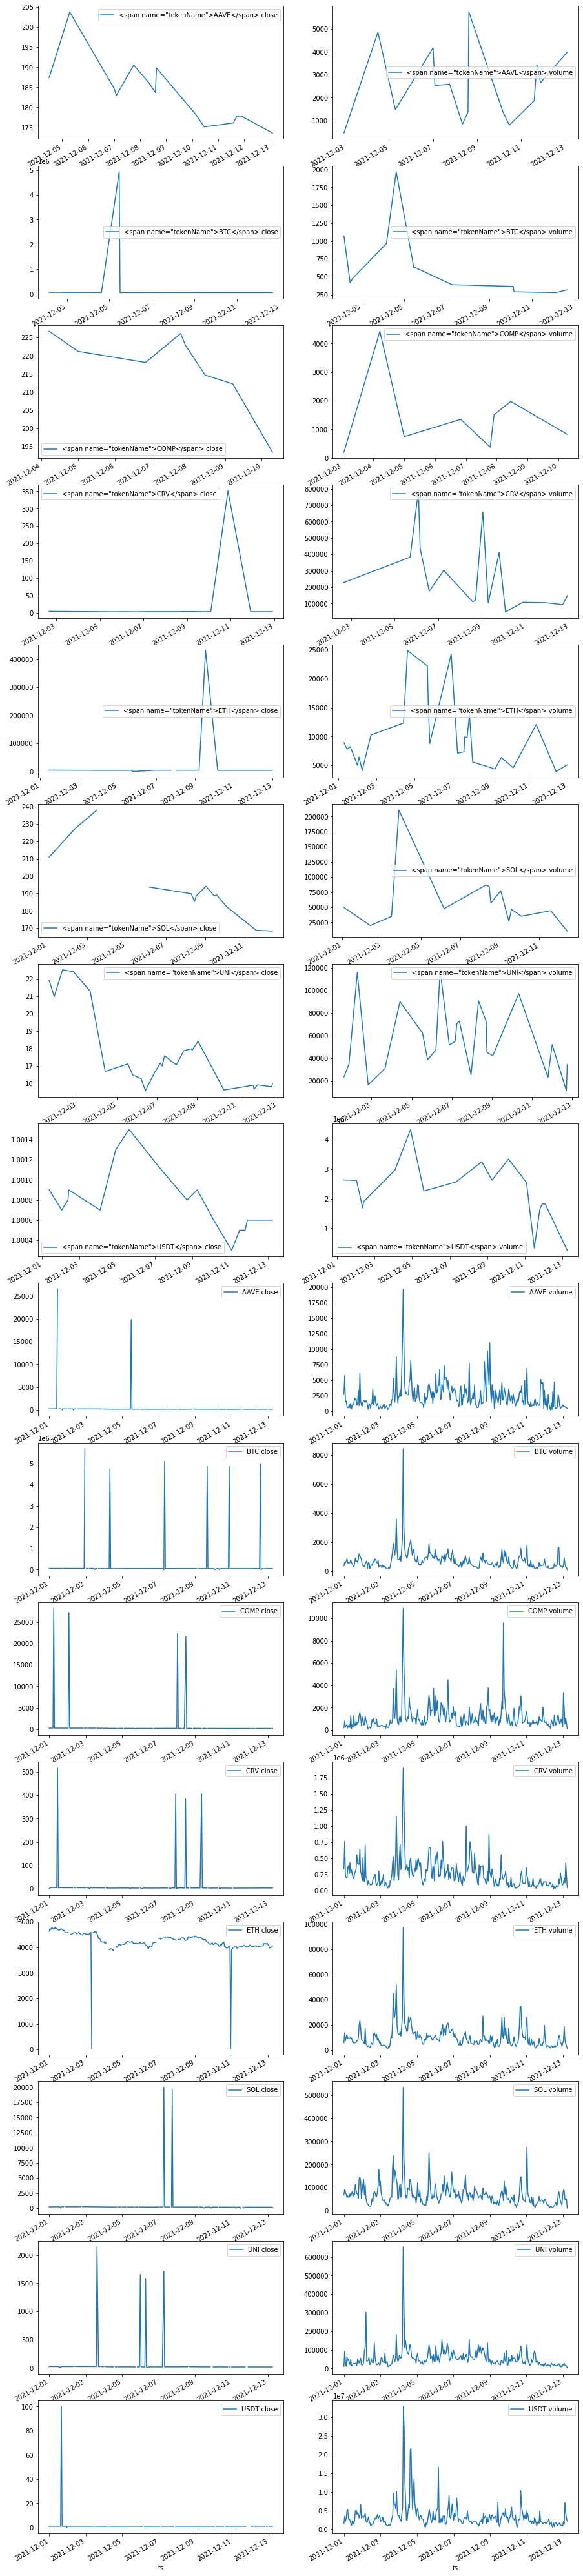

In [74]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=tokens_in_df.size, ncols=2, figsize=(15, 5 * tokens_in_df.size))

row = 0
for label, df_token in df[['token', 'close','volume']].groupby('token'):
    df_token['close'].plot(ax=axes[row, 0], label = label + ' close')
    df_token['volume'].plot(ax=axes[row, 1], label = label + ' volume')
    axes[row, 0].legend()
    axes[row, 1].legend()
    row += 1

### Observations:
1. missing values for high, low, close columns ✅
2. volumeUSD column empty - need to be filled ✅
3. messy token names ✅
4. there are duplicate rows ✅
5. outliers for close price series ✅
6. spike on volume on 12/4 - likely not outlier due to market drop 

#### 1. Deduplicate

In [76]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2360 entries, 2021-12-01 00:00:00 to 2021-12-13 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2360 non-null   float64
 1   high       1910 non-null   float64
 2   low        2104 non-null   float64
 3   close      2244 non-null   float64
 4   volume     2360 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2360 non-null   object 
 7   chain      2360 non-null   object 
dtypes: float64(6), object(2)
memory usage: 165.9+ KB


#### 2. Clean up token names

In [91]:
front_dummy = '<span name="tokenName">'
back_dummy = '</span>'
df.loc[df['token'].str.contains(front_dummy),'token'] = df.loc[df['token'].str.contains(front_dummy),'token'].str.replace(front_dummy, '').str.replace(back_dummy,'')


/Users/sunyi/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [92]:
df['token'].value_counts()

SOL     295
COMP    295
AAVE    295
UNI     295
BTC     295
ETH     295
USDT    295
CRV     295
Name: token, dtype: int64

check plots again:

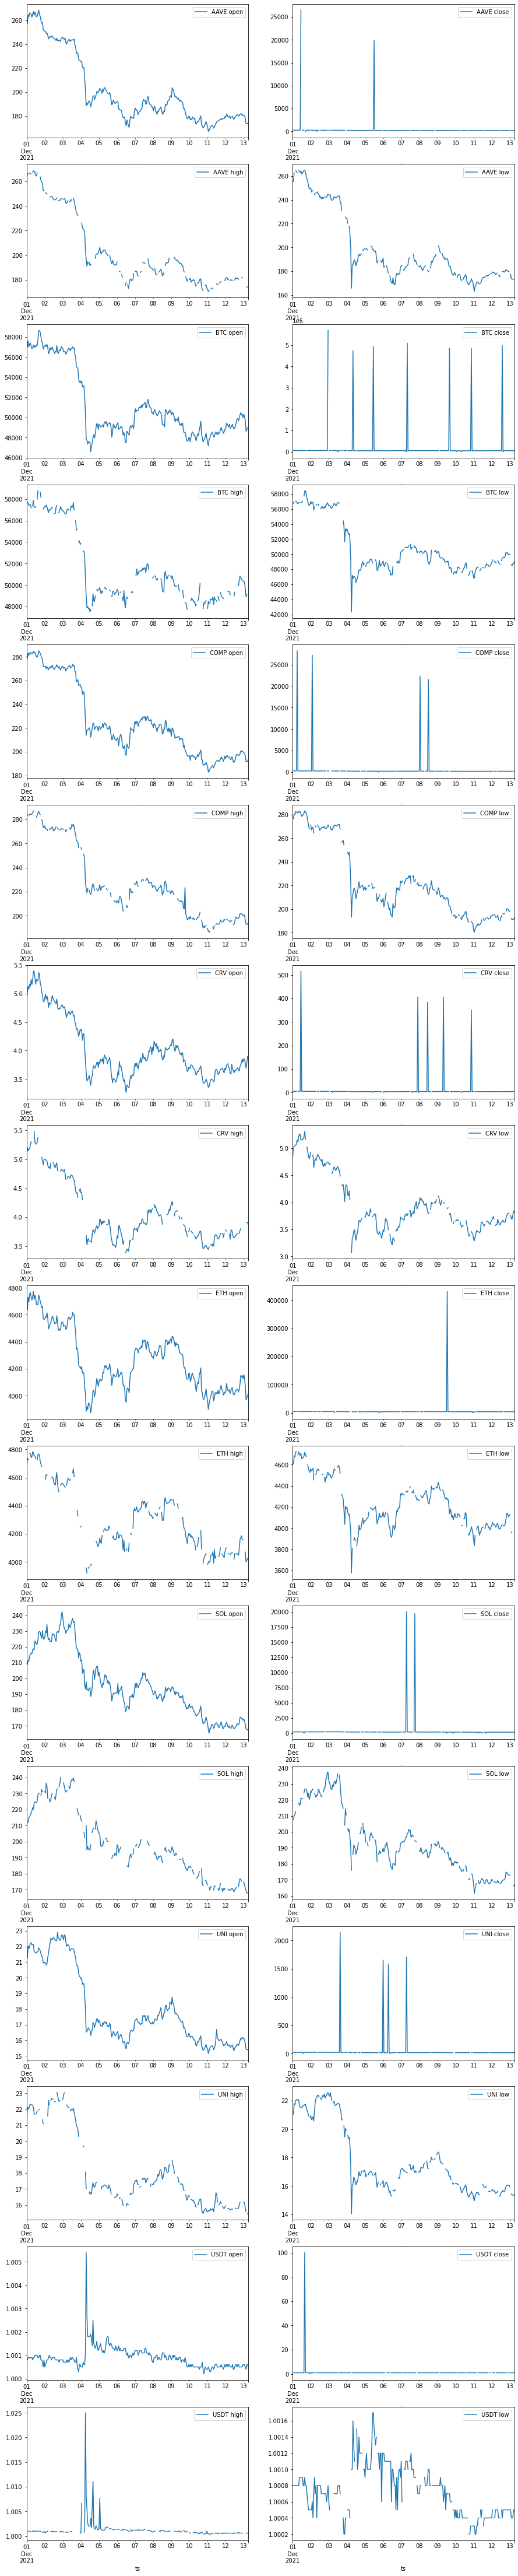

In [102]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=tokens_in_df.size * 2, ncols=2, figsize=(15, 5 * tokens_in_df.size * 2))

row = 0
for label, df_token in df[['token', 'open','close', 'high', 'low']].groupby('token'):
    df_token['open'].plot(ax=axes[row, 0], label = label + ' open')
    df_token['close'].plot(ax=axes[row, 1], label = label + ' close')
    axes[row, 0].legend()
    axes[row, 1].legend()
    row += 1
    df_token['high'].plot(ax=axes[row, 0], label = label + ' high')
    df_token['low'].plot(ax=axes[row, 1], label = label + ' low')
    axes[row, 0].legend()
    axes[row, 1].legend()
    row += 1

#### 3. Fill missing values

Taking open price for any missing high or low, and take the average of high and low to fill missing close price.

In [106]:
df.loc[df['high'].isnull(), 'high'] = df.loc[df['high'].isnull(), 'open']
df.loc[df['low'].isnull(), 'low'] = df.loc[df['low'].isnull(), 'open']
df.loc[df['close'].isnull(), 'close'] = 0.5 * (df.loc[df['close'].isnull(), 'high'] + df.loc[df['close'].isnull(), 'low'])

/Users/sunyi/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### 4. Treat outliers

Assuming close price 2x or more from open price to be outliers. Replace with average of high and low.

In [119]:
df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.2)]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,4.8830,5.0723,4.8264,0.050295,3.395810e+05,NaN,CRV,ETH
2021-12-01 14:00:00,21.6462,21.8957,21.6436,0.216669,2.549481e+04,NaN,UNI,ETH
2021-12-01 15:00:00,224.5410,229.2300,224.4140,2.290990,1.160250e+05,NaN,SOL,SOL
2021-12-01 17:00:00,265.2620,265.2620,262.9060,2.632300,9.809190e+02,NaN,AAVE,ETH
2021-12-01 23:00:00,1.0008,1.0009,1.0005,0.010005,2.967950e+06,NaN,USDT,USDT
2021-12-02 08:00:00,245.8090,247.5180,245.7290,2.467160,3.166740e+02,NaN,AAVE,ETH
2021-12-03 05:00:00,4.5835,4.5835,4.5533,0.046530,8.807282e+04,NaN,CRV,ETH
2021-12-03 08:00:00,4584.3400,4588.0300,4548.0600,45.722700,2.468821e+03,NaN,ETH,ETH
2021-12-03 12:00:00,56891.7000,57209.7000,56858.0200,570.337400,1.897550e+02,NaN,BTC,BTC


In [120]:
df.loc[df.close / df.open >= 2, 'close'] = 0.5 * (df.loc[df.close / df.open >= 2, 'high'] + df.loc[df.close / df.open >= 2, 'low'])
df.loc[df.close / df.open <= 0.2, 'close'] = 0.5 * (df.loc[df.close / df.open <= 0.2, 'high'] + df.loc[df.close / df.open <= 0.2, 'low'])

/Users/sunyi/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


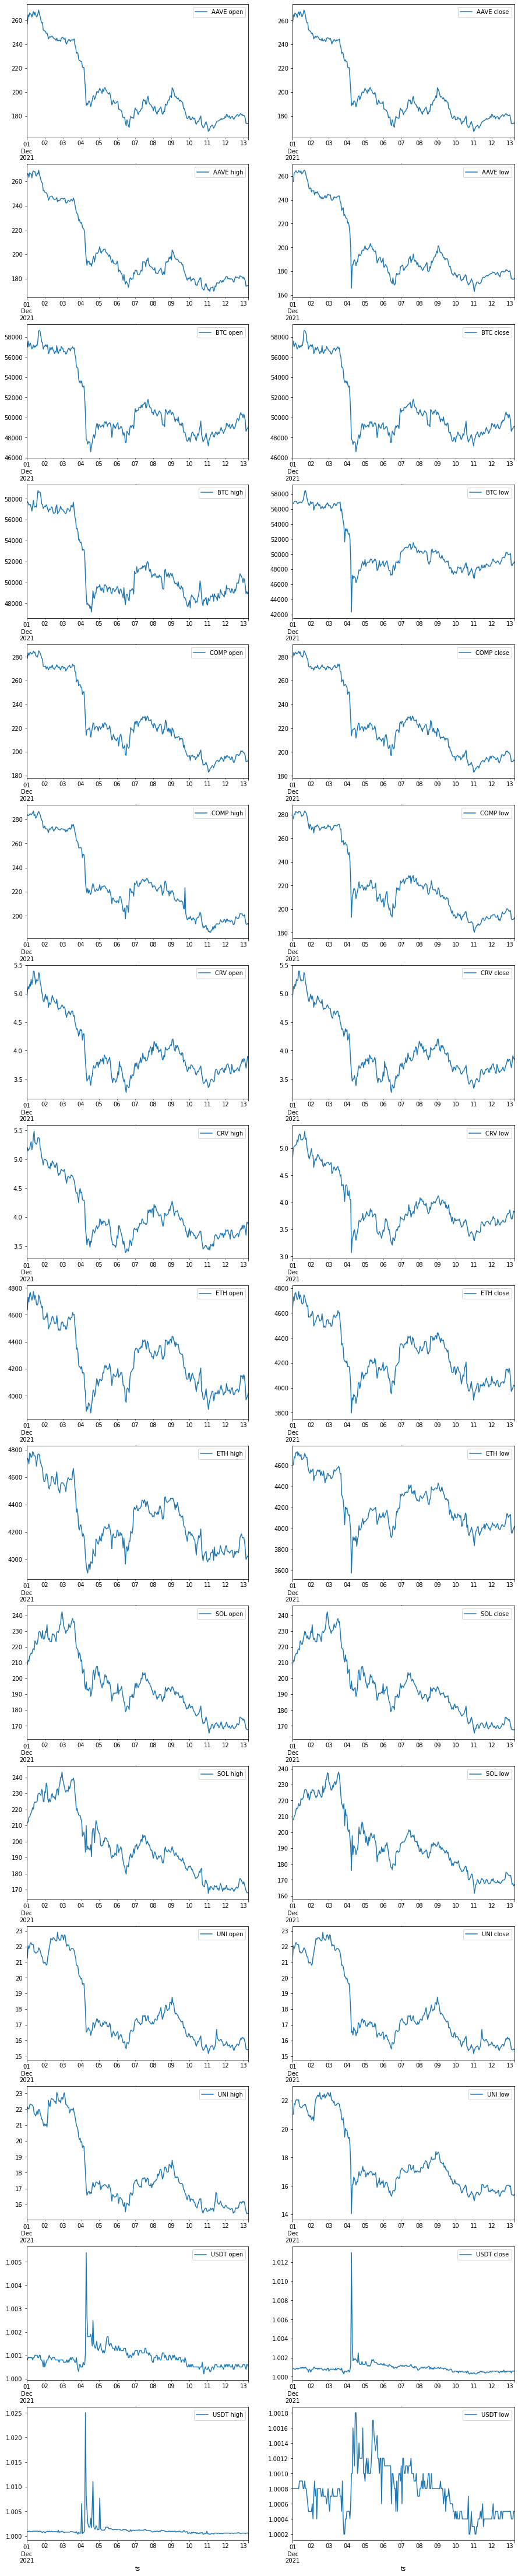

In [121]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=tokens_in_df.size * 2, ncols=2, figsize=(15, 5 * tokens_in_df.size * 2))

row = 0
for label, df_token in df[['token', 'open','close', 'high', 'low']].groupby('token'):
    df_token['open'].plot(ax=axes[row, 0], label = label + ' open')
    df_token['close'].plot(ax=axes[row, 1], label = label + ' close')
    axes[row, 0].legend()
    axes[row, 1].legend()
    row += 1
    df_token['high'].plot(ax=axes[row, 0], label = label + ' high')
    df_token['low'].plot(ax=axes[row, 1], label = label + ' low')
    axes[row, 0].legend()
    axes[row, 1].legend()
    row += 1

charts look good now.

#### 5. Calculate volumeUSD column and summarize by chain

In [124]:
df.volumeUSD = df.close * df.volume
df

/Users/sunyi/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,210.3120,210.3120,208.4320,208.6760,70031.618000,1.461392e+07,SOL,SOL
2021-12-01 00:00:00,280.5900,281.4000,278.3000,278.7000,207.849000,5.792752e+04,COMP,ETH
2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.0780,2730.299000,7.018998e+05,AAVE,ETH
2021-12-01 00:00:00,21.2004,21.3115,21.0337,21.2659,12406.133674,2.638276e+05,UNI,ETH
2021-12-01 00:00:00,57321.4100,57451.0500,56814.3400,56987.9700,388.482022,2.213880e+07,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-12-13 06:00:00,167.4800,167.8000,166.9300,167.6400,11191.365000,1.876120e+06,SOL,SOL
2021-12-13 06:00:00,49065.4500,49108.3300,48970.1000,49087.7600,123.274547,6.051271e+06,BTC,BTC
2021-12-13 06:00:00,3.8700,3.8700,3.8200,3.8450,45270.080000,1.740635e+05,CRV,ETH


<AxesSubplot:xlabel='chain'>

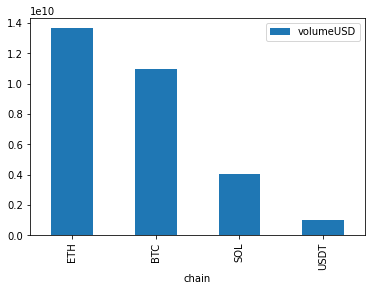

In [138]:
df.groupby(['chain'])[['volumeUSD']].sum().sort_values(by='volumeUSD', ascending=False).plot(kind='bar')